In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.tseries.offsets import DateOffset

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import keras.backend as K

import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = np.random.seed(0)

### Load data and preprocessing

In [75]:
#reading and saving each stock data into a dictionary
file_path = "2020Q1Q2Q3Q4-2021Q1.xlsx"

sheets = pd.ExcelFile(file_path)

df_dic = {}

for sheet_name in sheets.sheet_names:
  df = pd.read_excel(file_path,sheet_name = sheet_name, index_col="Date", parse_dates=["Date"])
  df_dic[sheet_name] = df[:-1]

Data are loaded as a dict of dataframes (one for each sheet). The last row is omitted because doesn't represent data but just a summary.

In [76]:
df_dic

{'Russia - Sberbank Rossii PAO (S':                       Price    Open    High     Low    Vol.  Change %
 Date                                                                 
 2021-03-31 00:00:00  291.02     294  294.42  290.26  47.00M   -0.0076
 2021-03-30 00:00:00  293.25  294.86  295.72   291.5  38.81M   -0.0002
 2021-03-29 00:00:00   293.3  289.72  294.09  289.26  43.68M    0.0071
 2021-03-26 00:00:00  291.22  288.63  292.75  288.32  56.07M    0.0159
 2021-03-25 00:00:00  286.66   286.5  287.03  283.85  35.22M    0.0030
 ...                     ...     ...     ...     ...     ...       ...
 2020-01-10 00:00:00  258.19  257.86  259.25  256.88  18.85M    0.0008
 2020-01-09 00:00:00  257.99   259.4  261.76  257.01  38.33M   -0.0045
 2020-01-08 00:00:00  259.15  253.57  259.15  253.03  40.82M    0.0207
 2020-01-06 00:00:00   253.9  254.75  254.84   251.4  22.35M   -0.0043
 2020-01-03 00:00:00     255  255.99  258.19   253.7  35.85M    0.0010
 
 [311 rows x 6 columns],
 'Turkey - Koc 

In [77]:
company_name = list(df_dic.keys())

for i in range(len(company_name)):
      print(f"{i} {company_name[i]}")

0 Russia - Sberbank Rossii PAO (S
1 Turkey - Koc Holding AS (KCHOL)
2 Egypt - Medinet Nasr Housing (M
3 Brazil - Minerva SABrazil (BEEF
4 Argentina - Pampa Energia SA (P
5 Colombia - Cementos Argos SA (C
6 South Africa - Impala Platinum 
7 South Korea - Dongkuk Steel Mil


In [78]:

for key in df_dic:
    df = df_dic[key]
    #converting to float datatype and removing strings
    df['Vol.'] = df['Vol.'].str.replace('M', 'e6').str.replace('K', 'e3').str.replace('-', '0').astype(float)
    df = df.astype(float)

    #fixing datatime index
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    df_dic[key] = df
    print(key)
    df.info()
    print(df.tail())

Russia - Sberbank Rossii PAO (S
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 311 entries, 2020-01-03 to 2021-03-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     311 non-null    float64
 1   Open      311 non-null    float64
 2   High      311 non-null    float64
 3   Low       311 non-null    float64
 4   Vol.      311 non-null    float64
 5   Change %  311 non-null    float64
dtypes: float64(6)
memory usage: 17.0 KB
             Price    Open    High     Low        Vol.  Change %
Date                                                            
2021-03-25  286.66  286.50  287.03  283.85  35220000.0    0.0030
2021-03-26  291.22  288.63  292.75  288.32  56070000.0    0.0159
2021-03-29  293.30  289.72  294.09  289.26  43680000.0    0.0071
2021-03-30  293.25  294.86  295.72  291.50  38810000.0   -0.0002
2021-03-31  291.02  294.00  294.42  290.26  47000000.0   -0.0076
Turkey - Koc Holding AS (KCHOL)
<clas

In [79]:
df_dic['Russia - Sberbank Rossii PAO (S'].head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2020-01-03,255.00,255.99,258.19,253.70,35850000.0,0.0010
2020-01-06,253.90,254.75,254.84,251.40,22350000.0,-0.0043
2020-01-08,259.15,253.57,259.15,253.03,40820000.0,0.0207
2020-01-09,257.99,259.40,261.76,257.01,38330000.0,-0.0045
2020-01-10,258.19,257.86,259.25,256.88,18850000.0,0.0008


### EDA

1. checking missing values

In [80]:
for key in df_dic:
    print(f'{key} \n {df_dic[key].isnull().sum()}')

Russia - Sberbank Rossii PAO (S 
 Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64
Turkey - Koc Holding AS (KCHOL) 
 Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64
Egypt - Medinet Nasr Housing (M 
 Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64
Brazil - Minerva SABrazil (BEEF 
 Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64
Argentina - Pampa Energia SA (P 
 Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64
Colombia - Cementos Argos SA (C 
 Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64
South Africa - Impala Platinum  
 Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64
South Korea - Dongkuk Steel Mil 
 Price       0
Open        0
High        0
Low    

There are no missing values.

2) Visualize data to inspect outliers

In [88]:
#Ploting linechat to vizualize the stock price variation

def EDA_plot(df,name):
  plt.figure(figsize=(18,8))
  plt.fill_between(df.index, df['Low'], df['High'], alpha=0.3, label = " Low/High")
  plt.plot(df['Price'], linewidth=1, label = "Final Price")
  plt.title(f"Linechart - Price Plot: {name}")
  plt.legend()
  plt.show()


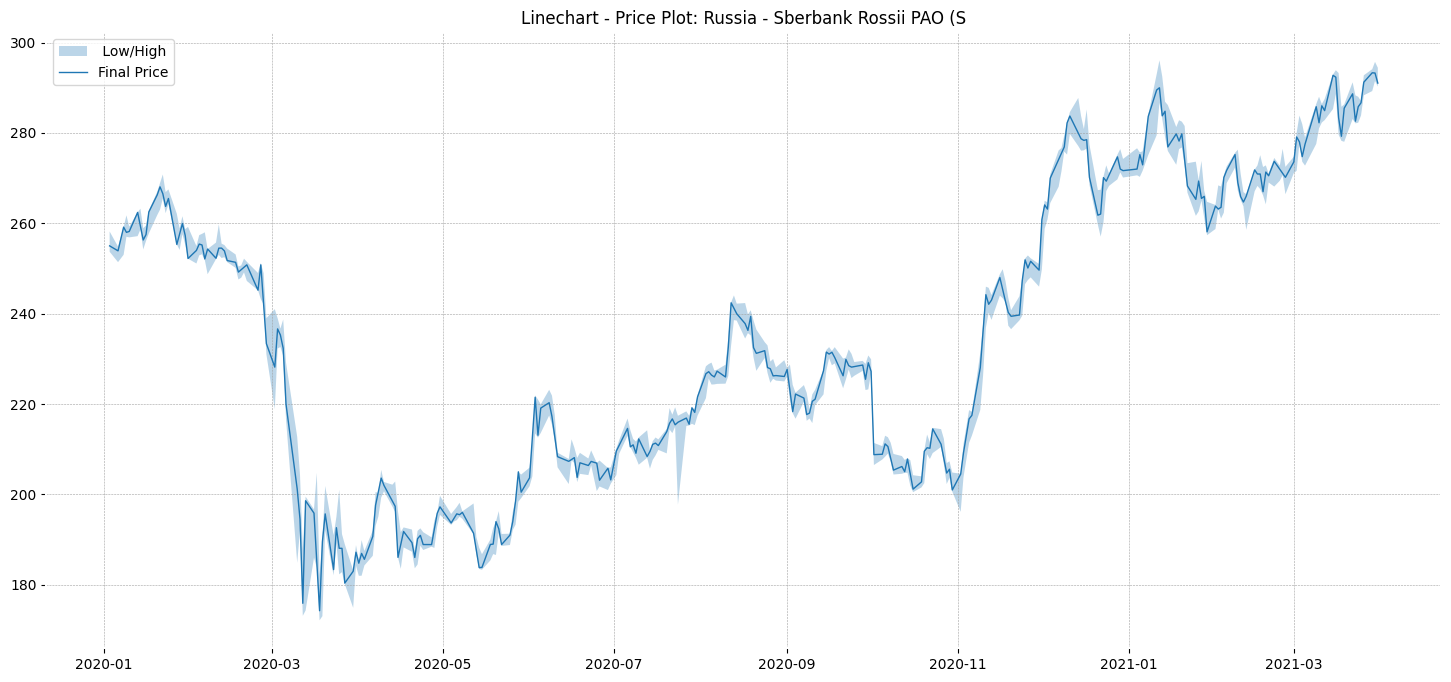

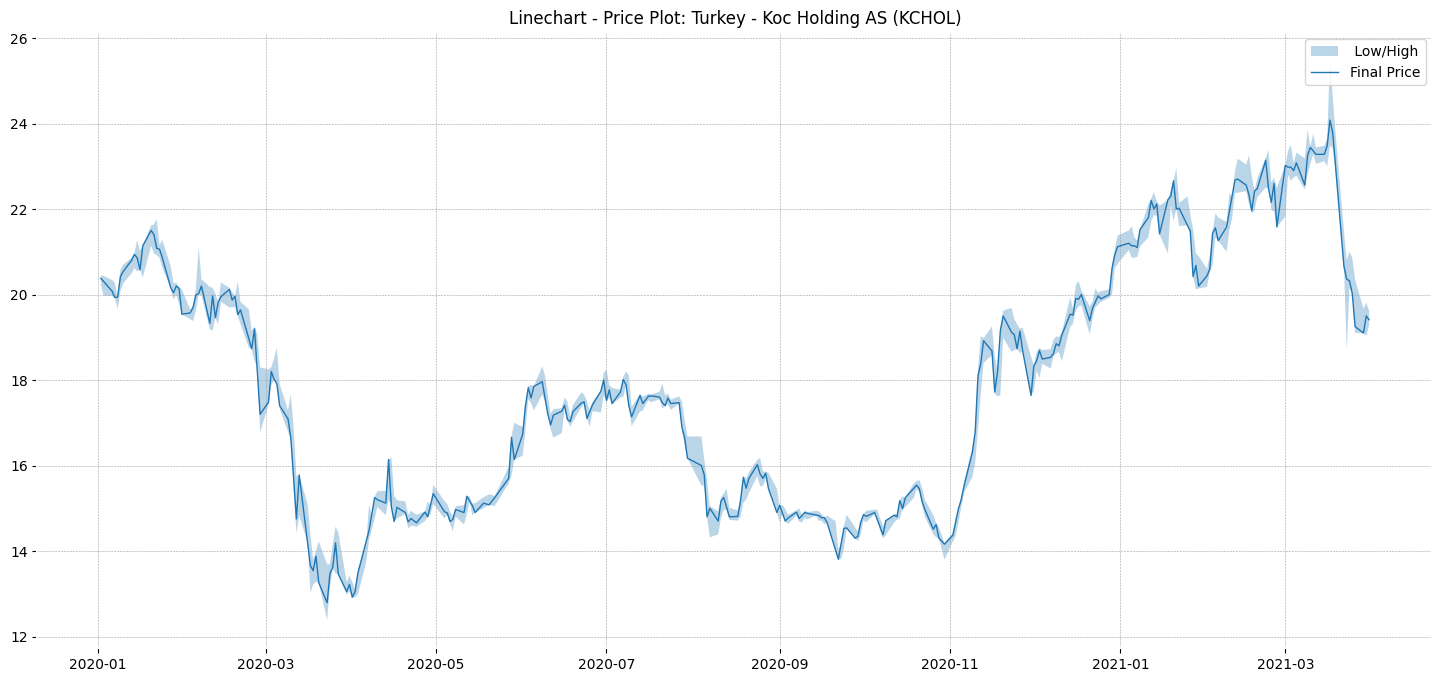

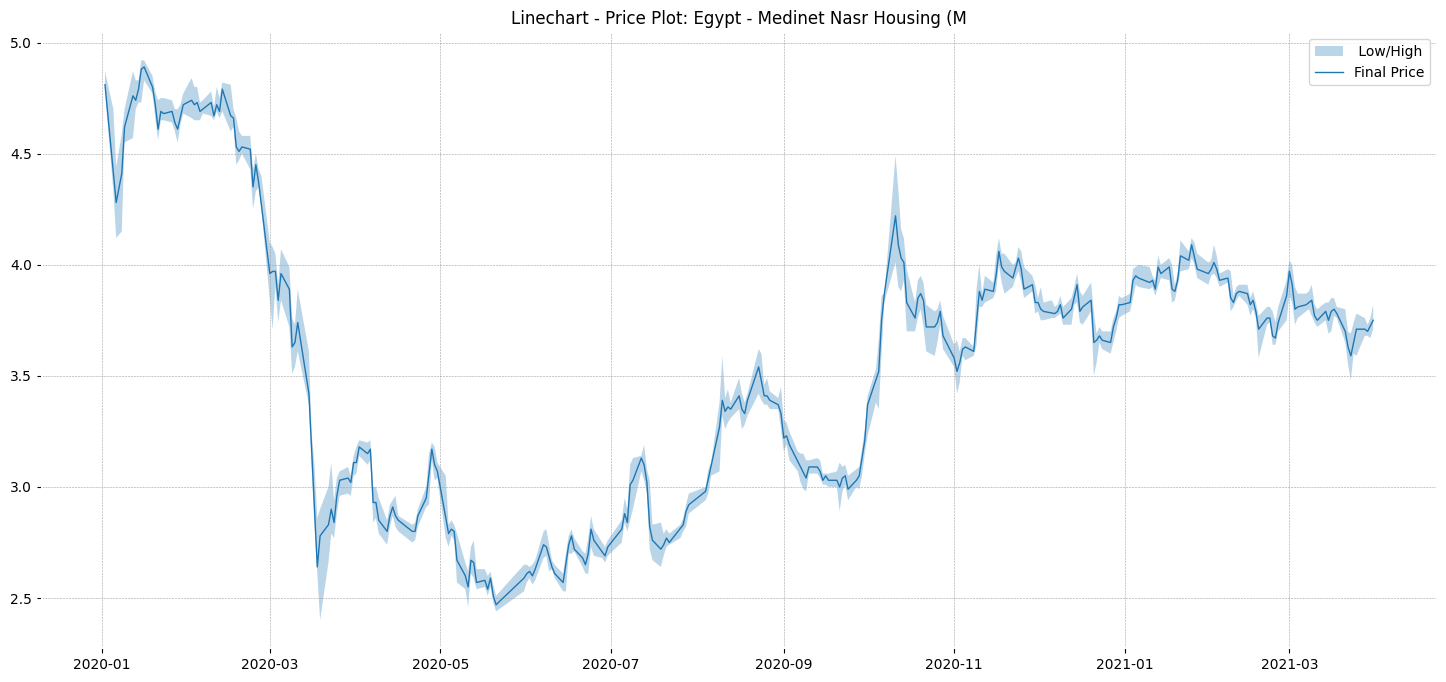

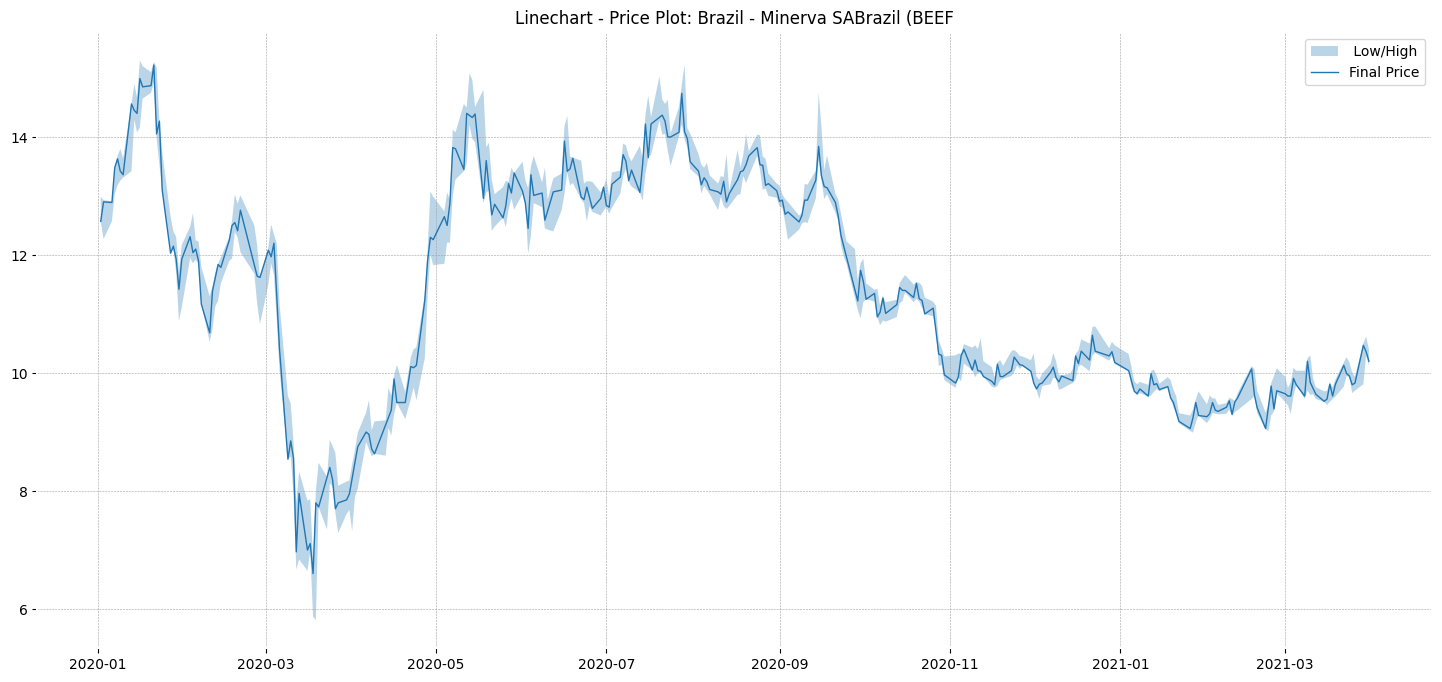

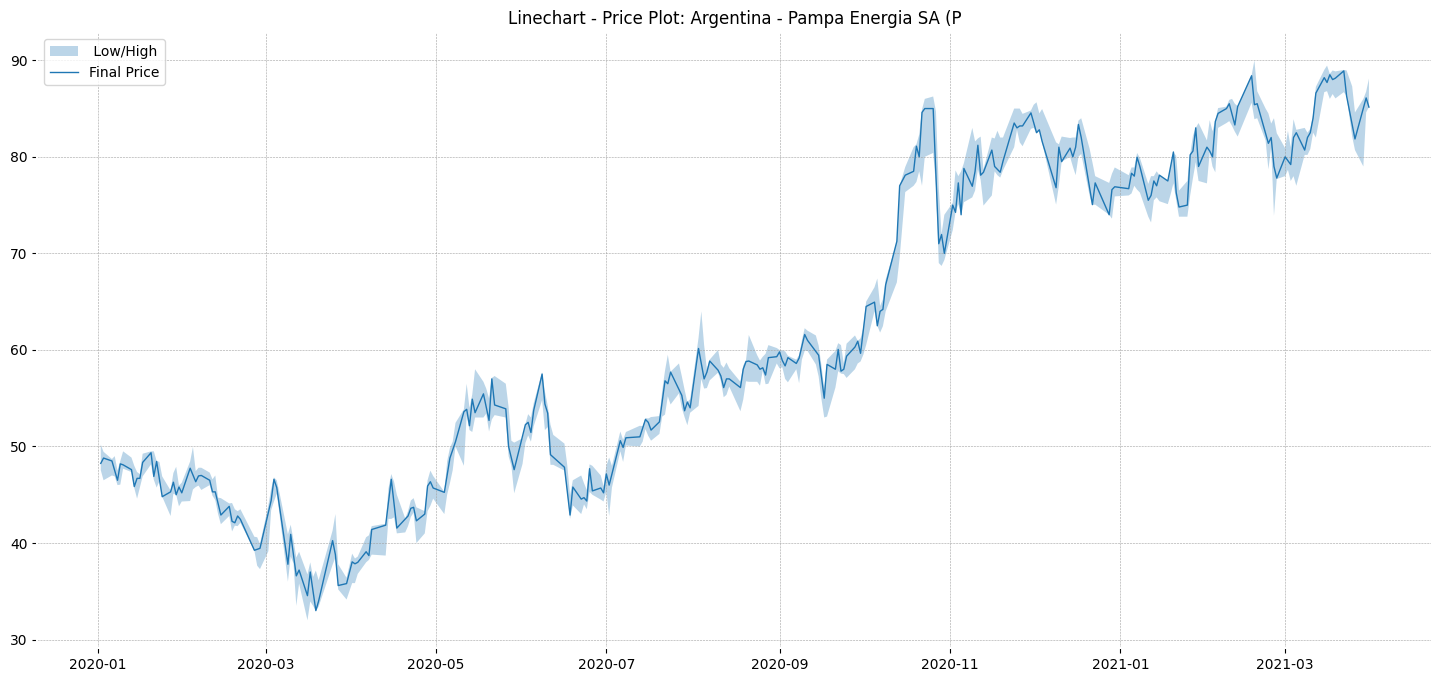

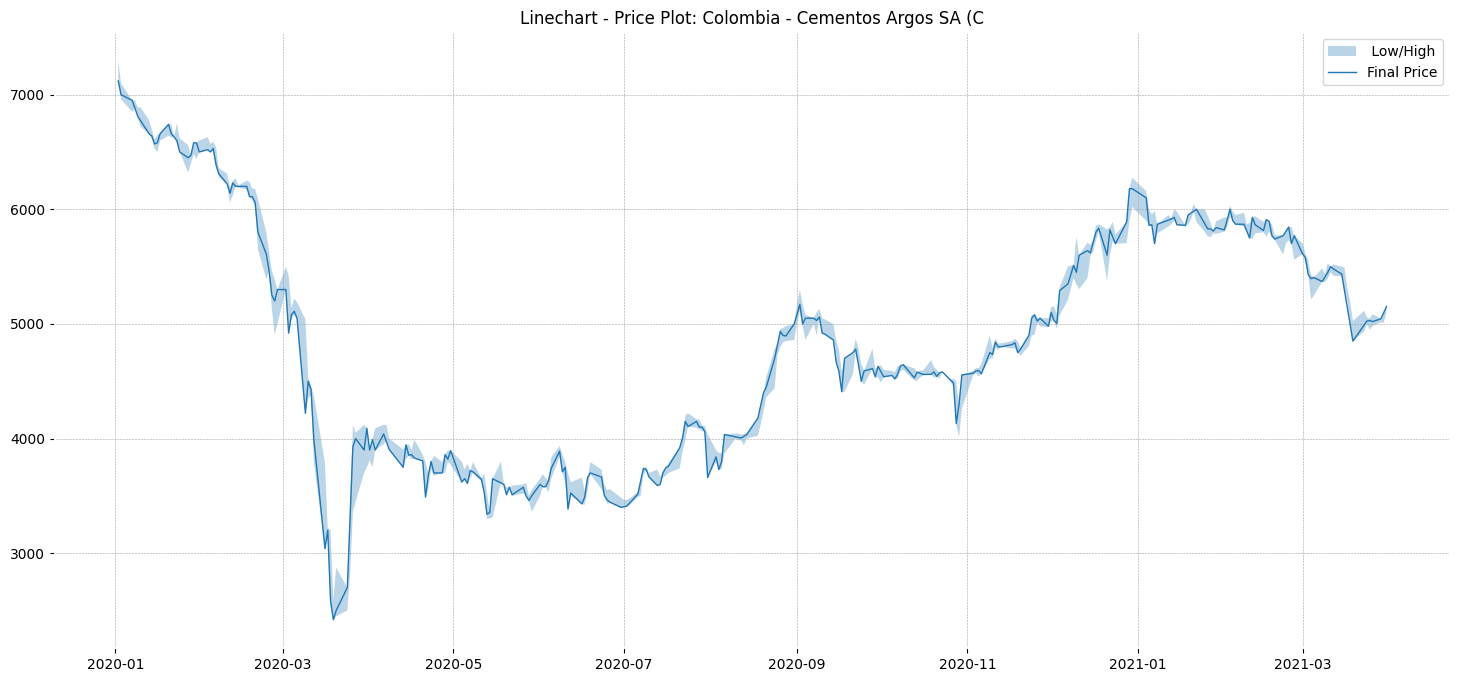

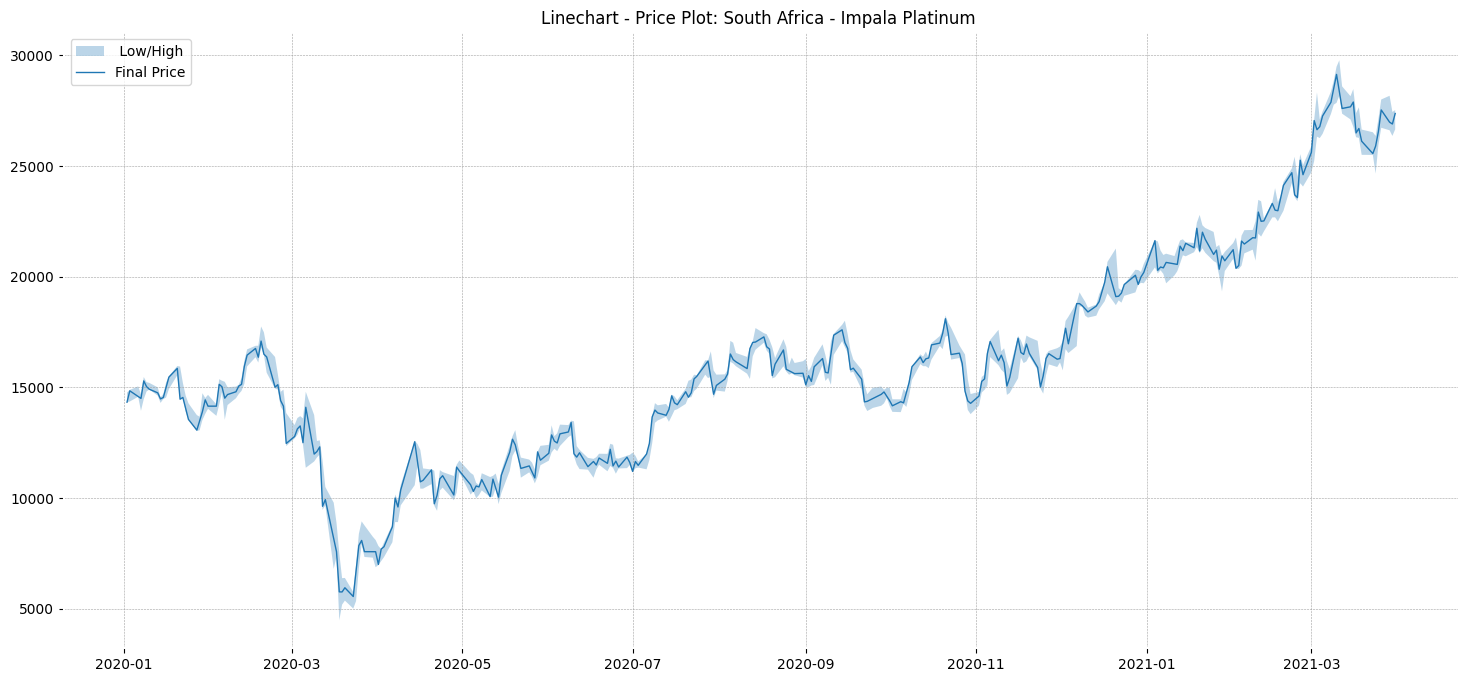

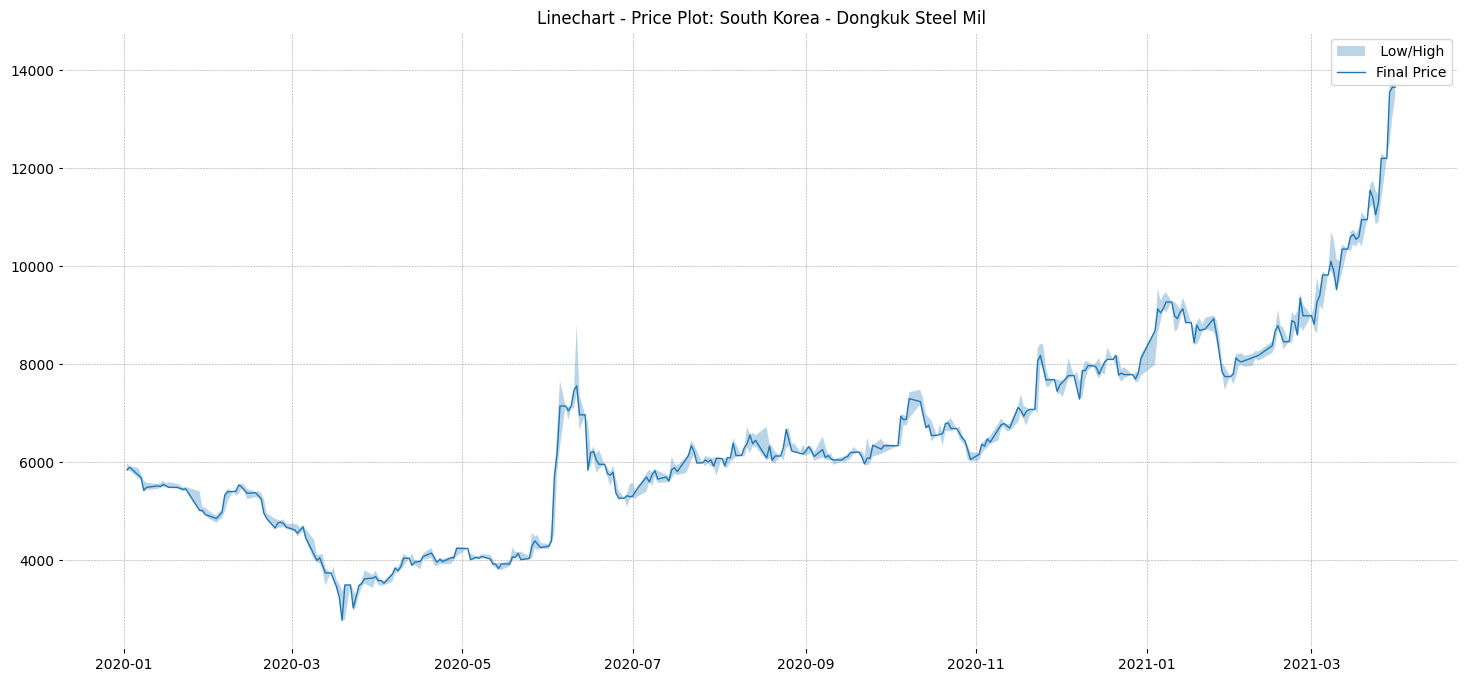

In [89]:
for key in df_dic:
    EDA_plot(df_dic[key], name = key)


Looking at the trend there are no specific outliers to evidence

### Forecasting with ARIMA